This tutorial was written by Jacob Valdez (1001628688) without any human assistance or copying any code. It represents a powerful introduction to regularization for any ML student.

# A Simple Demonstration of Overfitting

We've all done it. Have you ever studied all night for an exam but then realized that you were studying the wrong material? You were overfitting. The same can happen with machine learning models. Whether you're looking at an extremely simple linear regression model or a 1000-layer residual neural network, if not propperly regularized, the model can begin to systematically bias its performance around the training dataset. In this notebook, I want to show you how this can happen in the simpler case (linear regression model) and present one way to avoid minimizing overfitting.

Let's start by importing the libraries we'll need and building a plotting utility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython import display

def plot(true_points=None, pred_points=None, data_points=None, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    if true_points is not None:
        x_true, y_true = true_points
        ax.plot(x_true, y_true, 'g')
    
    if pred_points is not None:
        x_pred, y_pred = pred_points
        ax.plot(x_pred, y_pred, 'r')
    
    if data_points is not None:
        x_data, y_data = data_points
        ax.plot(x_data, y_data, 'bo')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')

Great. Imports and utilities are set up. Let's start by building a simple linear regression model. Formally, a linear regression model is a function of the form:

$$f(x) = w_0 + w_1 x + w_2 x^2 + ... + w_n x^n$$

For example, a zeroeth order polynomial is just a constant $f(x) = w_0$. A first order polynomial is a linear function $f(x) = w_0 + w_1 x$. A second order polynomial is a quadratic function $f(x) = w_0 + w_1 x + w_2 x^2$. And so on. The highest exponent determines the order of the polynomial.

Since we're dealing with linear combinations of the exponented value, we can represent our linear regression model $f(x)$ succinctly as a vector dot-product:

$$f(x) = \vec{w} \cdot \vec{x}$$

where $\vec{w} = \langle w_0 \ w_1 \ w_2 \ ... \ w_n \rangle$ is the vector of coefficients and $\vec{x} = \langle 1 \ x \ x^2 \ ... \ x^n \rangle$ is the vector of exponentiated values. Besides being succinct for in math, the dot-product operation is also a convenient way to perform linear regression model in code:

In [2]:
def model(x, w):
    """
    Linear regression model

    Computes f(x) = w_0 + w_1 x + w_2 x^2 + ... + w_n x^n
    for a given x and weights w.
    """

    # compute increasing exponents of x
    X = np.stack([x**i for i in range(w.shape[0])])

    # compute dot-product of weights and x
    return w.dot(X)

Let's try out this function with a simple example.

In [3]:
x = 2
w = np.array([3, 4, 5])
y = model(x, w)

x, w, y

(2, array([3, 4, 5]), 31)

Does the math look correct? $\vec{w} \cdot \vec{x} = 3 + 4 \cdot 2 + 5 \cdot 2^2 = 31 = y$. Correct! 

Before moving on, I forgot to emphasize that our linear regression model is going to be operating on lots and lots of data. Currently, `model` must be called for each data point. This is inefficient. We can speed up the process by using a matrix multiplication:

In [4]:
def model_matmul(xs, w):
    """
    Linear regression model

    Computes f(x) = w_0 + w_1 x + w_2 x^2 + ... + w_n x^n
    for a given set of xs and weights w.
    """
    
    # compute increasing exponents of x
    X = np.stack([xs**i for i in range(w.shape[0])], axis=1)

    # compute dot-product of weights and *all* xs using matrix multiplication
    return X @ w

Let's make sure our new model is correct by comparing it to the old one.

In [5]:
xs = np.array([1, 2, 3, 4, 5, 6, 7])
w = np.array([3, 4, 5])

ys = [model(x, w) for x in xs]
ys_matmul = model_matmul(xs, w)

ys==ys_matmul

array([ True,  True,  True,  True,  True,  True,  True])

Looks good! Now its time to build vectors for our data points and targets. In the real-world, you'd be loading your data from a database or file, but I'm going to keep it simple with:

$$x_{data} \sim \mathcal{U}(0,1)$$ 
and 
$$y_{data} = \sin(2 \pi x_{data}) + \zeta$$

with $\zeta \sim \mathcal{N}(0,1)$ and 20 data points. 

Ideally, our data points approximate the true function 
$$y_{true} = \sin(2 \pi x_{true})$$ 
for $x_{true} \in [0,1]$. Let's see this in code:

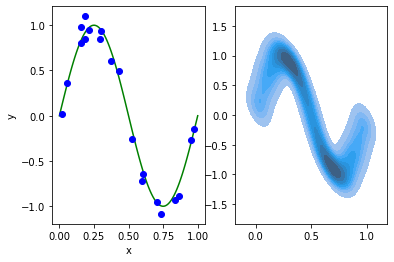

In [6]:
np.random.seed(42)  # set seed for reproducibility

x_data = np.random.uniform(0, 1, size=20)
y_data = np.sin(2 * np.pi * x_data) + np.random.normal(0, 0.1, size=20)

x_true = np.linspace(0, 1, 100)
y_true = np.sin(2 * np.pi * x_true)

# plot data points and true function
fig, ax = plt.subplots(1, 2)
plot(true_points=(x_true, y_true), data_points=(x_data, y_data), ax=ax[0])
# plot kde of data points
_x_data_kde = np.linspace(0, 1, 10000)
_y_data_kde = np.sin(2 * np.pi * _x_data_kde) + np.random.normal(0, 0.1, size=10000)
sns.kdeplot(x=_x_data_kde, y=_y_data_kde, ax=ax[1], shade=True)
plt.show()

Now its time to train our model. We'll split the data into training and testing sets.

In [7]:
x_train = x_data[:10]
y_train = y_data[:10]
x_test = x_data[10:]
y_test = y_data[10:]

Training the model is easy. There are faster methods in the one-dimensional case, but I'm going to use backpropagation to illustrate the overfitting problem. If you aren't familiar with backpropagation, it treats the backwards propagation of error as a linear algebra problem solved locally at each node in the computation graph. We're fortunate to have a simple model: a linear combination of the exponented values combined with some loss function (e.g. MSE).

$$f(x) = \vec{w} \cdot \vec{x}$$
$$\mathcal{L}(f(x), y) = (f(x) - y)^2$$

Now we train by finding the vector $\vec{w}$ that minimizes the loss function $\mathcal{L}$. Formally, this is

$$\min_{\vec{w}} (\vec{w} \cdot \vec{x} - y)^2$$

Going backwards, we derive our parameter gradients:

$$d\mathcal{L} = 1 $$
$$de = 2 (f(x) - y) \mathcal{L}$$
$$df(x) = de$$
$$d\vec{w} = \vec{x}^T \cdot df(x)$$

Just to stay consistant with deep learning conventions, we'll run an iterative $\eta$-weighted update step instead of moving the parameters all at once. In code this becomes:

In [8]:
def backprop(xs, y_true, w, lr=0.1):

    # build power-bases of xs
    X = np.stack([xs**i for i in range(w.shape[0])], axis=1)  # [n_samples, order]

    # forward pass
    y_pred = X @ w  # [n_samples, order] x [order, 1] = [n_samples]
    err = y_pred - y_true  # [n_samples]
    loss = np.sum(err**2)  # []

    # compute gradient
    dloss = 1  # []
    derr = 2 * err * dloss  # [n_samples]
    dy_pred = derr  # [n_samples]
    dw = X.T @ dy_pred  # [order, n_samples] x [n_samples] = [order]

    # update weights
    w = w - lr * dw

    return w, loss

Let's run a few iterations of the update step. If it's working, we should see the weights begin to converge on the true function.

Epoch: 10	Loss:  2.440	Val. Loss:  3.208	
Epoch: 20	Loss:  1.548	Val. Loss:  2.831	
Epoch: 30	Loss:  1.124	Val. Loss:  2.549	
Epoch: 40	Loss:  0.908	Val. Loss:  2.399	
Epoch: 50	Loss:  0.795	Val. Loss:  2.322	
Epoch: 60	Loss:  0.735	Val. Loss:  2.280	
Epoch: 70	Loss:  0.701	Val. Loss:  2.255	
Epoch: 80	Loss:  0.681	Val. Loss:  2.236	
Epoch: 90	Loss:  0.667	Val. Loss:  2.219	
Epoch: 100	Loss:  0.656	Val. Loss:  2.202	


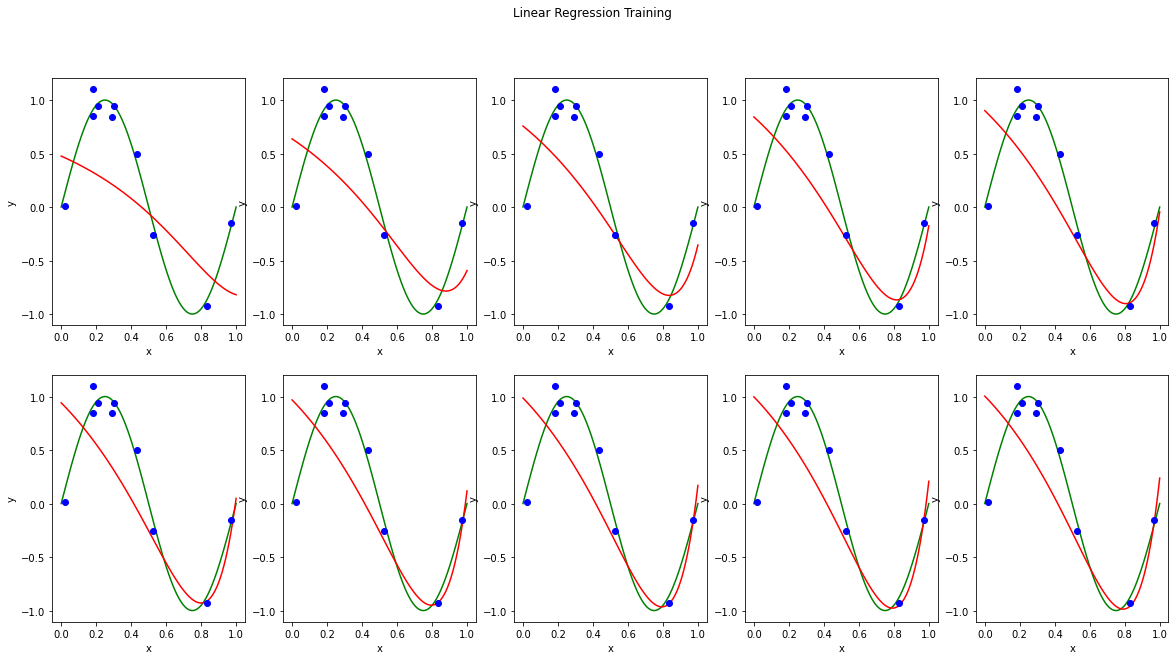

In [9]:
def train_loop(w_init, lr=0.1, n_epochs=100, quiet=False):

     xs = np.linspace(0, 1, 100)
     w = w_init

     if not quiet:
          fig, ax = plt.subplots(2, 5, figsize=(20, 10))
     for i in range(1, 101):

          w, loss = backprop(x_train, y_train, w, lr=0.05)

          if i % 10 == 0:

               y_pred = model_matmul(xs, w)
               _, val_loss = backprop(x_test, y_test, w)

               if not quiet:
                    print(f'Epoch: %d\tLoss: %6.3f\tVal. Loss: %6.3f\t' % (i, loss, val_loss))               
                    n = i//10 - 1
                    plot(true_points=(x_true, y_true), 
                         pred_points=(xs, y_pred), 
                         data_points=(x_test, y_test), 
                         ax=ax[n//5, n%5])

     if not quiet:
          plt.suptitle('Linear Regression Training')
          plt.show()

     return w

np.random.seed(42)  # set seed for reproducibility
w = np.random.normal(0, 0.1, size=9)
_ = train_loop(w)

Everything looks good! Now let's crank up the linear model order and see what happens.

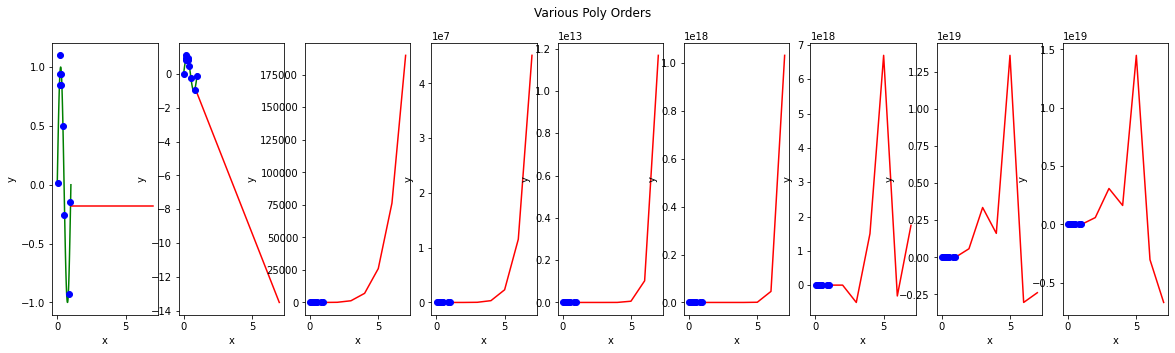

In [10]:
orders = [0, 1, 6, 9, 16, 23, 47, 93, 127]
fig, ax = plt.subplots(1, len(orders), figsize=(20, 5))

for i, order in enumerate(orders):
    np.random.seed(42)  # set seed for reproducibility
    w_init = np.random.normal(0, 0.1, size=(order+1))
    w_fin = train_loop(w_init, quiet=True)
    plot(true_points=(x_true, y_true), 
         pred_points=(xs, model_matmul(xs, w_fin)), 
         data_points=(x_test, y_test), 
         ax=ax[i])

fig.suptitle('Various Poly Orders')
plt.show()

Note that as we increase the order, the model becomes more complex. When pitted up against simple linear regression, the model started overfitting. What can we do to prevent this?

Regularization to the rescue! We'll add a small amount of L2 regularization to our loss function to reduce the overfitting. It goes like this:

$$\mathcal{L}(f(x), y) = (f(x) - y)^2 + \lambda \sum_{i=1}^n w_i^2$$

Backpropagation now includes the additional term:

$$d\vec{w} = \vec{x}^T \cdot df(x) + \underbrace{2 \lambda \vec{w}}_{\text{L2 loss penalty}}$$

In code, this becomes:

In [11]:
def backprop_L2(xs, y_true, w, lambda_L2=0.0, lr=0.1):

    # build power-bases of xs
    X = np.stack([xs**i for i in range(w.shape[0])], axis=1)  # [n_samples, order]

    # forward pass
    y_pred = X @ w  # [n_samples, order] x [order, 1] = [n_samples]
    err = y_pred - y_true  # [n_samples]
    loss = np.sum(err**2)  # []

    # compute gradient
    dloss = 1  # []
    derr = 2 * err * dloss  # [n_samples]
    dy_pred = derr  # [n_samples]
    dw = X.T @ dy_pred  # [order, n_samples] x [n_samples] = [order]
    dw = dw + 2 * lambda_L2 * w  # L2 regularization

    # update weights
    w = w - lr * dw

    return w, loss

Let's see if this makes any difference ($\lambda=1$) in our training loop. I'm going to first run a quick sanity check to make sure the new code didn't break our loss function.

Epoch: 10	Loss:  2.503	Val. Loss:  3.239	
Epoch: 20	Loss:  1.679	Val. Loss:  2.958	
Epoch: 30	Loss:  1.305	Val. Loss:  2.715	
Epoch: 40	Loss:  1.111	Val. Loss:  2.572	
Epoch: 50	Loss:  1.004	Val. Loss:  2.489	
Epoch: 60	Loss:  0.941	Val. Loss:  2.438	
Epoch: 70	Loss:  0.903	Val. Loss:  2.405	
Epoch: 80	Loss:  0.879	Val. Loss:  2.381	
Epoch: 90	Loss:  0.863	Val. Loss:  2.363	
Epoch: 100	Loss:  0.853	Val. Loss:  2.349	


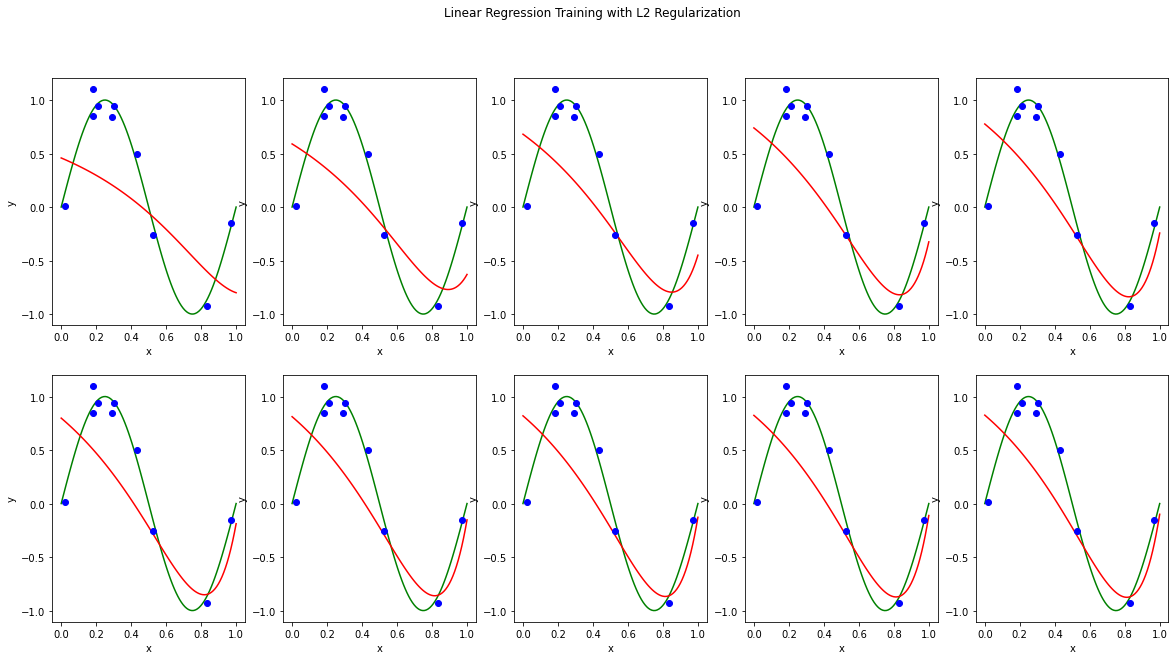

In [12]:
def train_loop(w_init, lr=0.1, lambda_L2=0.0, n_epochs=100, quiet=False):

     xs = np.linspace(0, 1, 100)
     w = w_init

     if not quiet:
          fig, ax = plt.subplots(2, 5, figsize=(20, 10))
     for i in range(1, 101):

          w, loss = backprop_L2(x_train, y_train, w, lambda_L2=lambda_L2, lr=0.05)

          if i % 10 == 0:

               y_pred = model_matmul(xs, w)
               _, val_loss = backprop_L2(x_test, y_test, w, lambda_L2=0.0)

               if not quiet:
                    print(f'Epoch: %d\tLoss: %6.3f\tVal. Loss: %6.3f\t' % (i, loss, val_loss))               
                    n = i//10 - 1
                    plot(true_points=(x_true, y_true), 
                         pred_points=(xs, y_pred), 
                         data_points=(x_test, y_test), 
                         ax=ax[n//5, n%5])

     if not quiet:
          plt.suptitle('Linear Regression Training with L2 Regularization')
          plt.show()

     return w

np.random.seed(42)  # set seed for reproducibility
w = np.random.normal(0, 0.1, size=9)
_ = train_loop(w, lambda_L2=0.1)

Good. Okay, let's compare various combinations of poly order with and without regularization. Then we'll make some conclusions on the L2 approach to combat overfitting. 

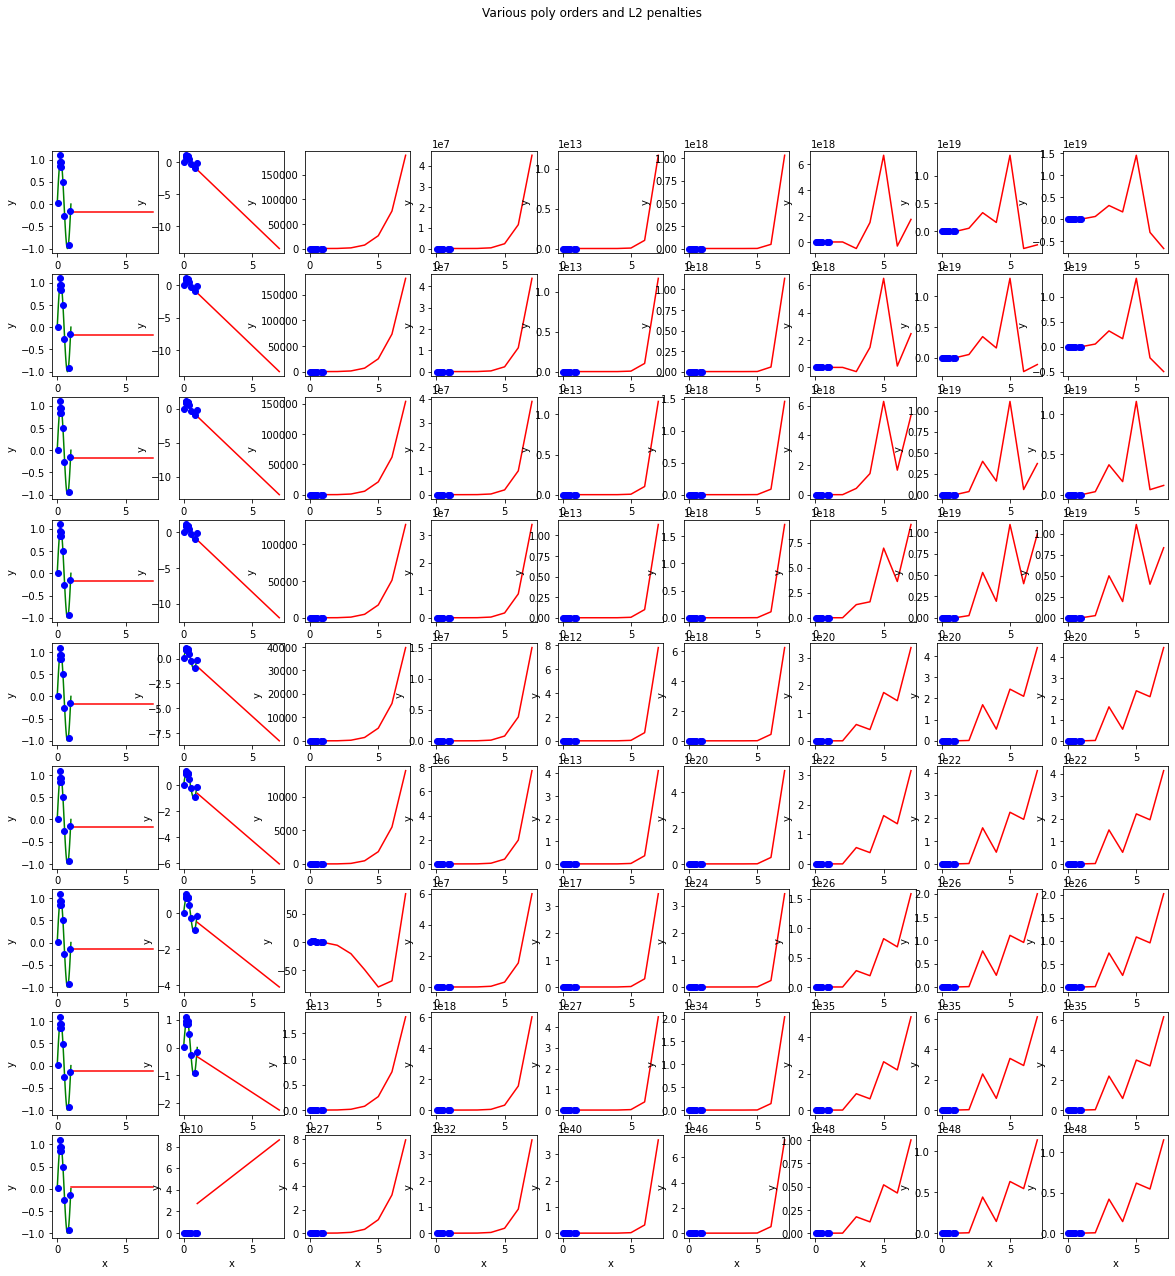

In [13]:
orders = [0, 1, 6, 9, 16, 23, 47, 93, 127]
lambda_L2 = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

fig, ax = plt.subplots(len(lambda_L2), len(orders), figsize=(20, 20))

for i, l2 in enumerate(lambda_L2):
    for j, order in enumerate(orders):
        np.random.seed(42)  # set seed for reproducibility
        w_init = np.random.normal(0, 0.1, size=(order+1))
        w_fin = train_loop(w_init, lambda_L2=l2, quiet=True)
        
        plot(true_points=(x_true, y_true), 
             pred_points=(xs, model_matmul(xs, w_fin)), 
             data_points=(x_test, y_test), 
             ax=ax[i,j])

fig.suptitle('Various poly orders and L2 penalties')
plt.show()

Remember: the Y axis goes down with increasing regularization weight and the X axis goes right with increasing model complexity. Notice that there is an inverse relationship symbiosis between the two. Either too much regularization or too much complexity will result in overfitting. However in balanced amount, one can compensate for the other.

Now let's do some qunatitative analysis. Look at the converging weights for the various orders with an without regularization:

In [14]:
orders = [0, 1, 6, 9, 12]
lambda_L2 = [0.0, 0.05, 0.1, 1.0]

for i, l2 in enumerate(lambda_L2):

    W = np.zeros((max(orders)+1, len(orders)))

    for j, order in enumerate(orders):
        np.random.seed(42)  # set seed for reproducibility
        w_init = np.random.normal(0, 0.1, size=(order+1))
        w_fin = train_loop(w_init, lambda_L2=l2, quiet=True)
        W[:order+1, j] = w_fin

    df = pd.DataFrame(W, 
        columns=['M = %d' % order for order in orders], 
        index=['$w_%d$' % i for i in range(max(orders)+1)])

    print(f'Results for lambda_L2={l2}')
    display.display(df)

Results for lambda_L2=0.0


,M = 0,M = 1,M = 6,M = 9,M = 12
$w_0$,-0.181312,0.889356,1.011410,0.992646,0.965060
$w_1$,0.000000,-2.058542,-1.936288,-1.588007,-1.423629
$w_2$,0.000000,0.000000,-1.470929,-1.473127,-1.401759
$w_3$,0.000000,0.000000,-0.393216,-0.717561,-0.760436
$w_4$,0.000000,0.000000,0.279790,-0.274529,-0.412731
$w_5$,0.000000,0.000000,0.891017,0.183676,-0.027199
$w_6$,0.000000,0.000000,1.483178,0.679129,0.415152
$w_7$,0.000000,0.000000,0.000000,0.803602,0.502132
$w_8$,0.000000,0.000000,0.000000,0.808431,0.481561
$w_9$,0.000000,0.000000,0.000000,0.984562,0.641549


Results for lambda_L2=0.05


,M = 0,M = 1,M = 6,M = 9,M = 12
$w_0$,-0.18041,0.817442,0.902521,0.901134,0.885514
$w_1$,0.00000,-1.928096,-1.708561,-1.456799,-1.326567
$w_2$,0.00000,0.000000,-1.288940,-1.317199,-1.270452
$w_3$,0.00000,0.000000,-0.383517,-0.662554,-0.711669
$w_4$,0.00000,0.000000,0.229137,-0.226755,-0.353808
$w_5$,0.00000,0.000000,0.743536,0.171248,-0.014136
$w_6$,0.00000,0.000000,1.197839,0.552970,0.325675
$w_7$,0.00000,0.000000,0.000000,0.681558,0.425206
$w_8$,0.00000,0.000000,0.000000,0.717707,0.442122
$w_9$,0.00000,0.000000,0.000000,0.843814,0.556434


Results for lambda_L2=0.1


,M = 0,M = 1,M = 6,M = 9,M = 12
$w_0$,-0.179517,0.754536,0.815610,0.825146,0.817953
$w_1$,0.000000,-1.813779,-1.528457,-1.346291,-1.242741
$w_2$,0.000000,0.000000,-1.147197,-1.191600,-1.162726
$w_3$,0.000000,0.000000,-0.371344,-0.613496,-0.665611
$w_4$,0.000000,0.000000,0.183540,-0.196354,-0.312780
$w_5$,0.000000,0.000000,0.624017,0.154501,-0.009227
$w_6$,0.000000,0.000000,0.984508,0.459909,0.262750
$w_7$,0.000000,0.000000,0.000000,0.586400,0.366492
$w_8$,0.000000,0.000000,0.000000,0.638809,0.404216
$w_9$,0.000000,0.000000,0.000000,0.732965,0.489727


Results for lambda_L2=1.0


,M = 0,M = 1,M = 6,M = 9,M = 12
$w_0$,-0.16483,0.262050,0.321044,0.329647,0.428620
$w_1$,0.00000,-0.902777,-0.584891,-0.595750,-0.537861
$w_2$,0.00000,0.000000,-0.462854,-0.493525,-0.463403
$w_3$,0.00000,0.000000,-0.251705,-0.294996,-0.283264
$w_4$,0.00000,0.000000,-0.083531,-0.134120,-0.134627
$w_5$,0.00000,0.000000,0.035094,-0.019304,-0.027975
$w_6$,0.00000,0.000000,0.115297,0.059340,0.045249
$w_7$,0.00000,0.000000,0.000000,0.111952,0.094313
$w_8$,0.00000,0.000000,0.000000,0.146317,0.126424
$w_9$,0.00000,0.000000,0.000000,0.167995,0.146750


Notice that while weights are increasing with increasing order, they remain relatively constant with increasing regularization weight. Again, we see the regularization term in action.

Now let's consider train vs. test error across the various orders with and without regularization: 

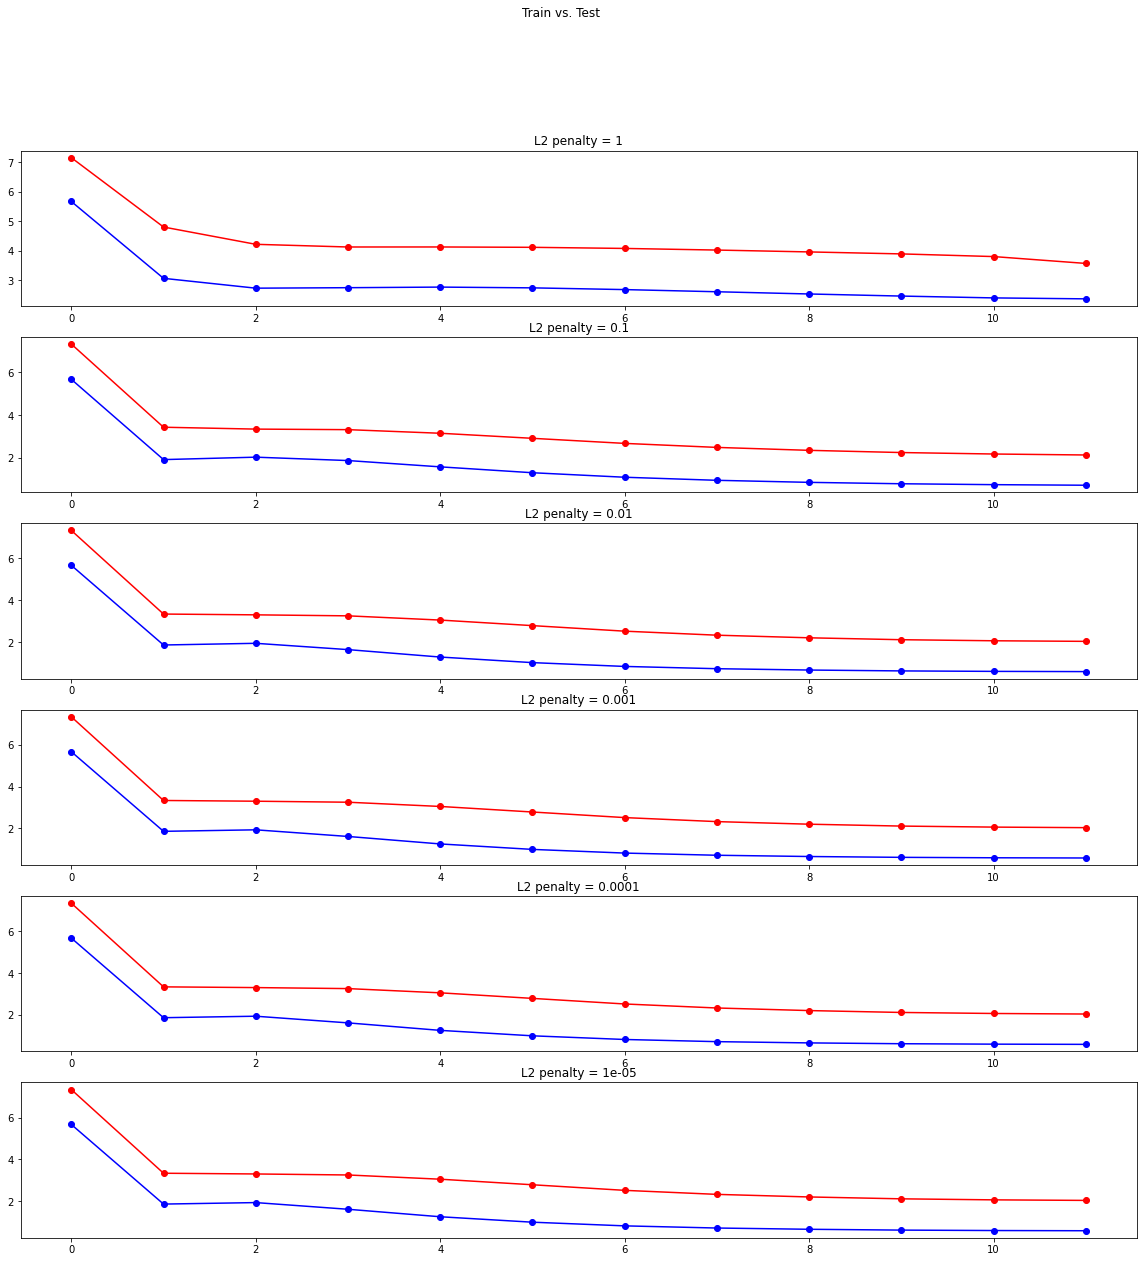

In [15]:
def loss(xs, y_true, w):
    X = np.stack([xs**i for i in range(w.shape[0])], axis=1)  # [n_samples, order]
    y_pred = X @ w  # [n_samples, order] x [order, 1] = [n_samples]
    err = y_pred - y_true  # [n_samples]
    return np.sum(err**2)  # []
      
orders = list(range(12))
lambda_L2 = [1, 1/10, 1/100, 1/1000, 1/10000, 1/100000]

fig, ax = plt.subplots(len(lambda_L2), 1, figsize=(20, 20))

for i, l2 in enumerate(lambda_L2):
    loss_train = []
    loss_test = []

    for j, order in enumerate(orders):
        np.random.seed(42)  # set seed for reproducibility
        w_init = np.random.normal(0, 0.1, size=(order+1))
        w_fin = train_loop(w_init, lambda_L2=l2, quiet=True)
        loss_train.append(loss(x_train, y_train, w_fin))
        loss_test.append(loss(x_test, y_test, w_fin))

    ax[i].title.set_text(f'L2 penalty = {l2}')
    ax[i].plot(orders, loss_train, 'bo-', label='Training')
    ax[i].plot(orders, loss_test, 'ro-', label='Validation')

fig.suptitle('Train vs. Test')
plt.show()

Well that wraps up a fun adventure! I hope you enjoyed this tutorial. If you have any questions, please let me know! I'm also attaching some references below for further reading on other applications of regularization:

## References
[GROKKING: GENERALIZATION BEYOND OVERFITTING ON SMALL ALGORITHMIC DATASETS](https://mathai-iclr.github.io/papers/papers/MATHAI_29_paper.pdf)

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Generalization Error Analysis of Neural networks with Gradient Based Regularization](https://arxiv.org/abs/2107.02797)